# Draw phylogenies of Ireland and global M. bovis samples

<div class="alert alert-block alert-info"><b>R Script to draw trees</b> </div>

In [4]:
setwd('/home/farrell/gitprojects/snipgenie/notebooks')
source('drawtrees.R')

In [2]:
options(repr.plot.width=22, repr.plot.height=15)

In [142]:
gltree <- read.tree('/storage/btbgenie/global_results/tree.newick')
glmeta <- read.table('/storage/btbgenie/global_results/metadata.csv',sep=',',
                      header=TRUE,row.names=1)
glmeta[] <- lapply(glmeta, as.character)
print (length(rownames(glmeta)))
iremeta <- read.table('/storage/btbgenie/all_ireland_results/metadata.csv',sep=',',
                      header=TRUE,row.names=1)
iremeta[] <- lapply(iremeta, as.character)
print (length(rownames(iremeta)))
iretree <- read.tree('/storage/btbgenie/all_ireland_results/tree.newick')

cmeta <- read.table('/storage/btbgenie/combined_results/metadata.csv',sep=',',header=TRUE,row.names=2)
cmeta[] <- lapply(cmeta, as.character)
#cmeta[is.na(cmeta)] <- "-"
#cmeta[] <- lapply(meta, as.character)
combtree <- read.tree('/storage/btbgenie/combined_results/tree.newick')

[1] 407
[1] 1435


## global

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


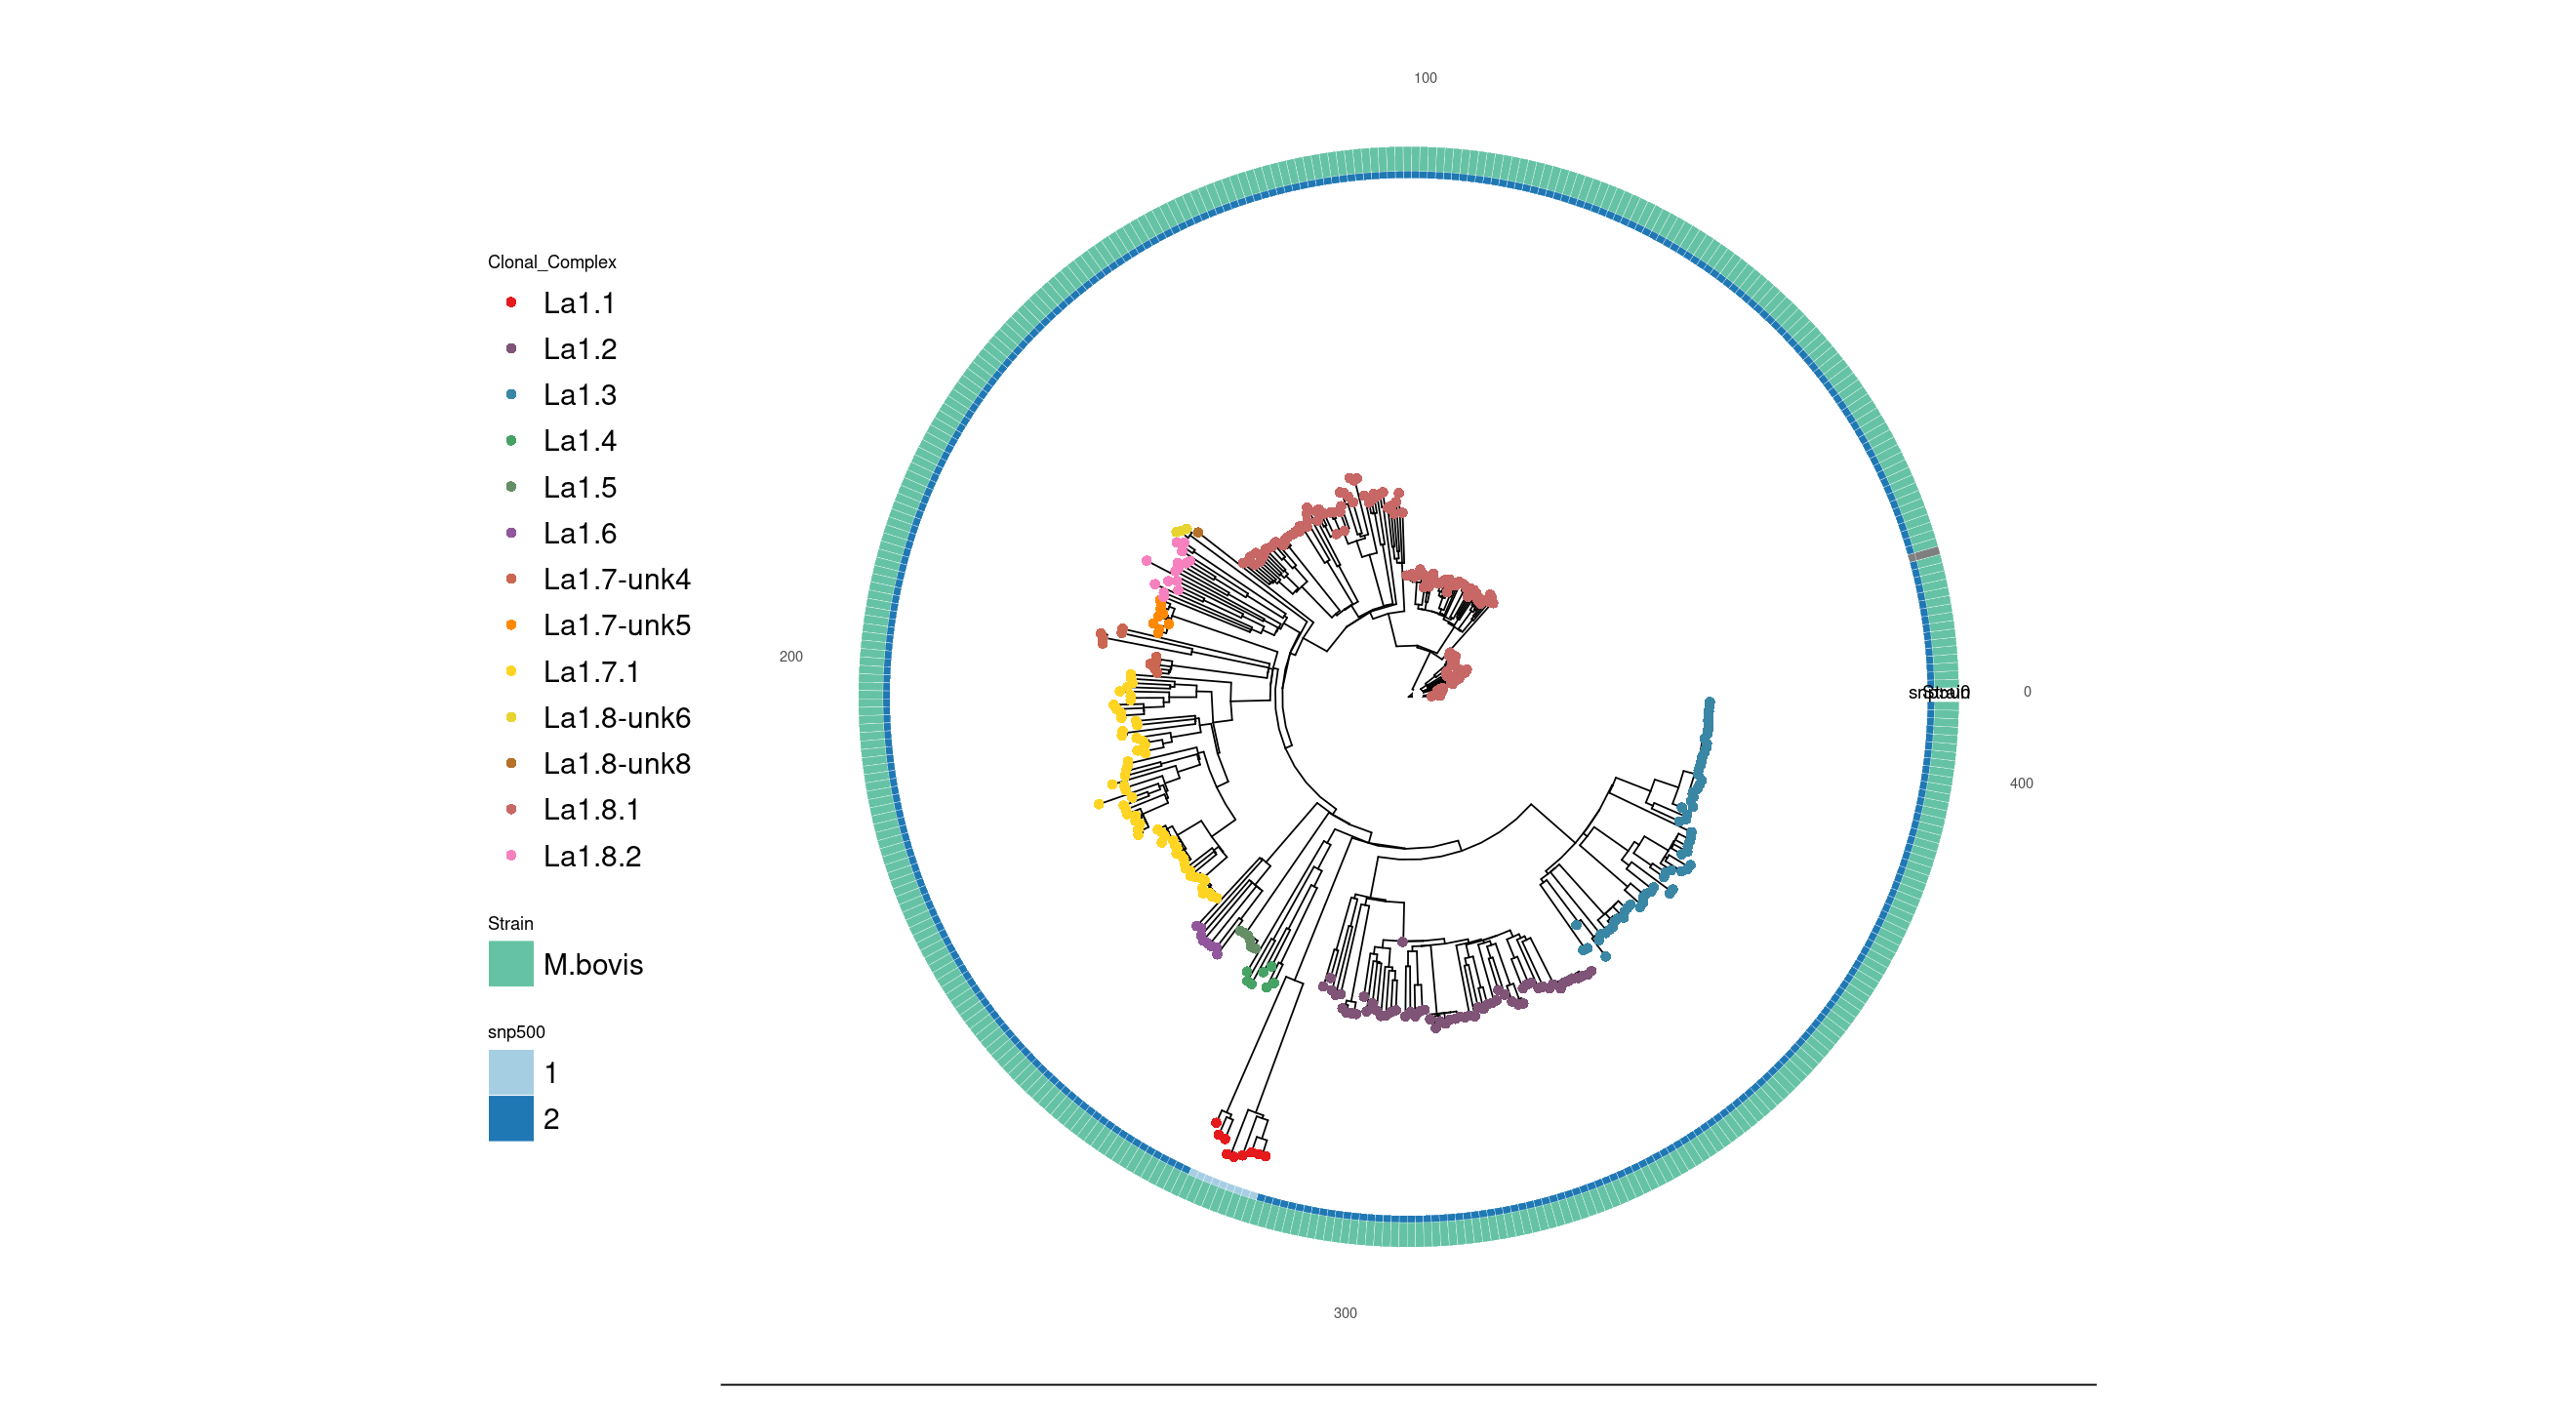

In [22]:
ggplottree(gltree, glmeta, layout='c', cols=c('Clonal_Complex','snp500','Strain'), cmaps=c('Set1','Paired','Set2'))

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


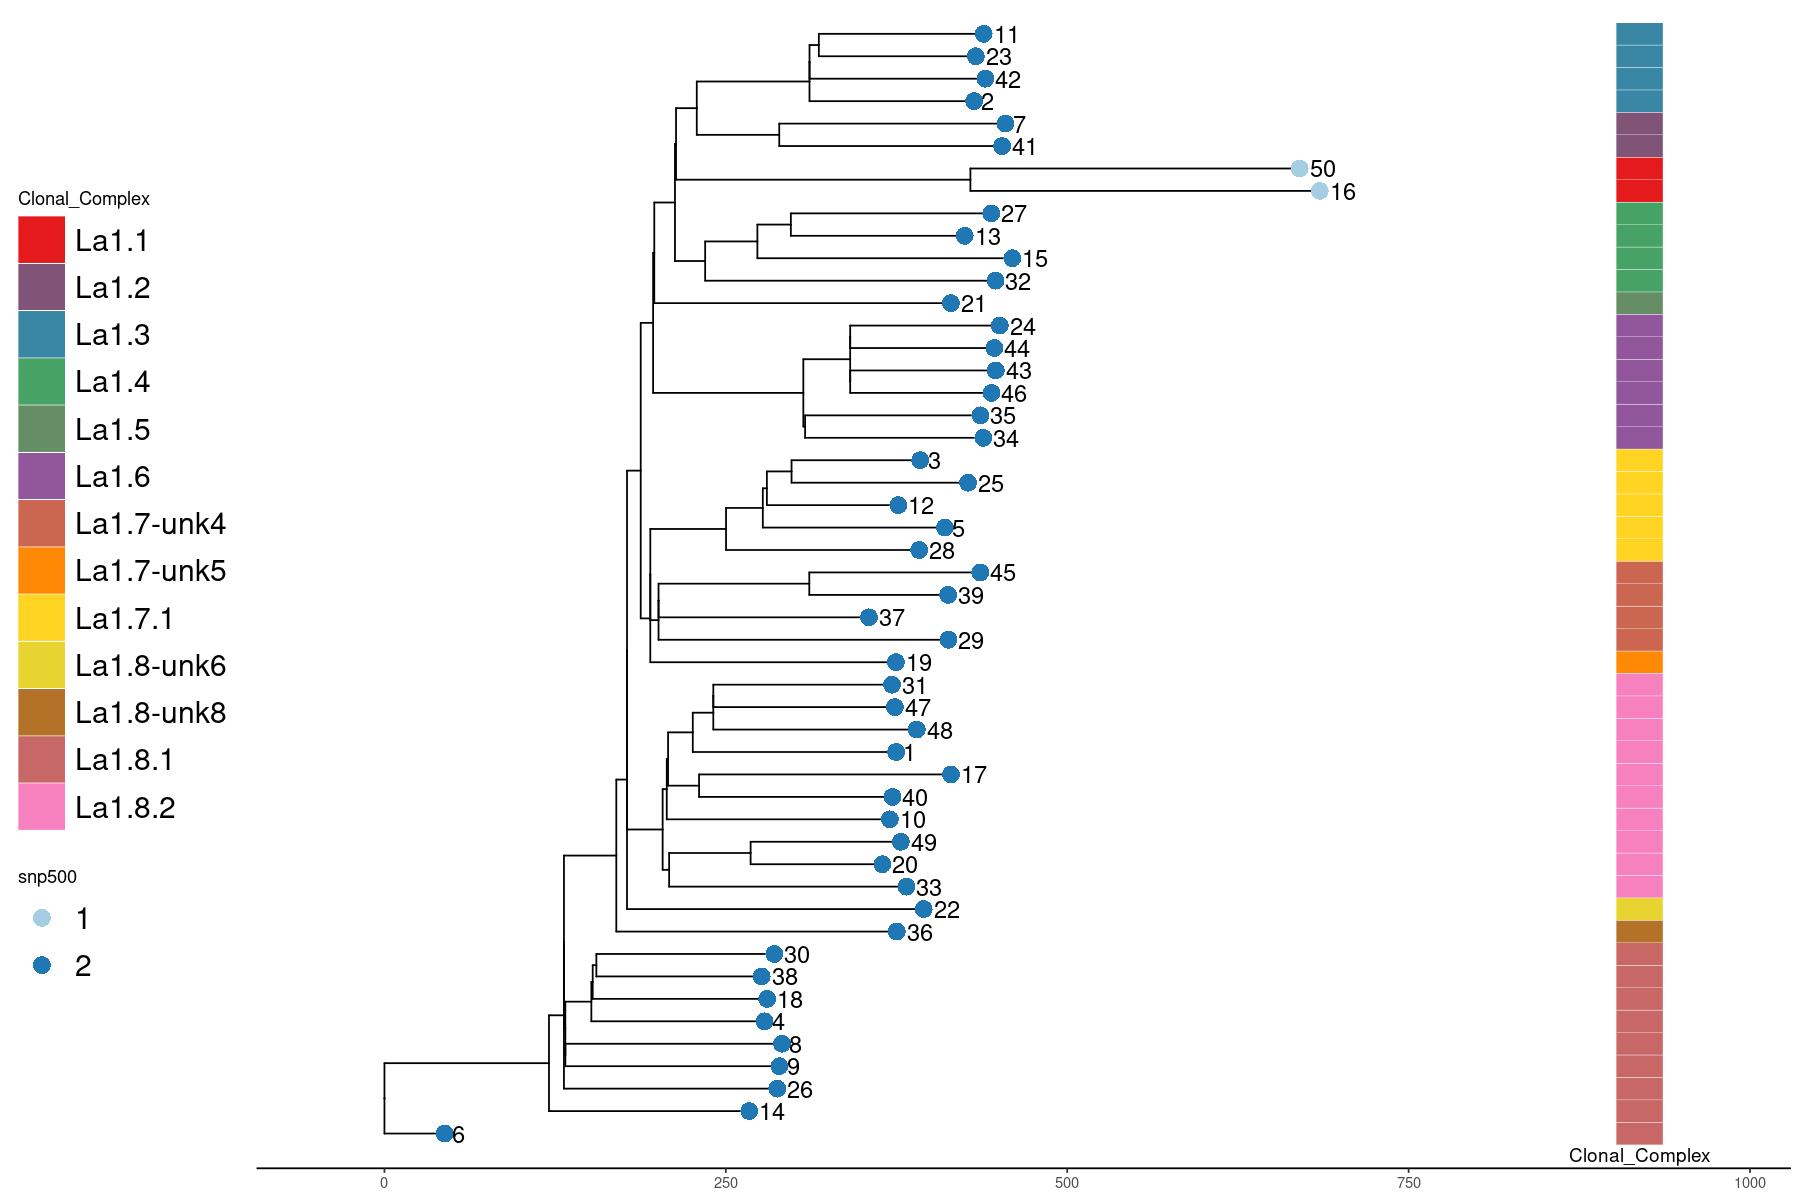

In [79]:
uniq <- row.names(distinct(glmeta,snp200,.keep_all = TRUE))
stree <- keep.tip(gltree, uniq)
#tips<-row.names(glmeta[glmeta$Clonal_Complex %in% c('La3','La2'),])
#stree <- drop.tip(stree, tips)
#stree <- root(stree,'ERR1082113')
ggplottree(stree, glmeta, layout='rect', cols=c('snp500','Clonal_Complex'), cmaps=c('Paired','Set1'), tiplabel='snp200', tipsize=5, offset=100)

In [ ]:
ggplottree(stree, glmeta, layout='rect', cols=c('snp200'), cmaps=c('Set1'), tipsize=5, offset=100)

## combined, global + Ireland

In [ ]:
#tree<-root(combtree,'ERR2513607')
ggplottree(combtree, cmeta, layout='c', cols=c('snp500'), cmaps=c('Paired','Set1'))

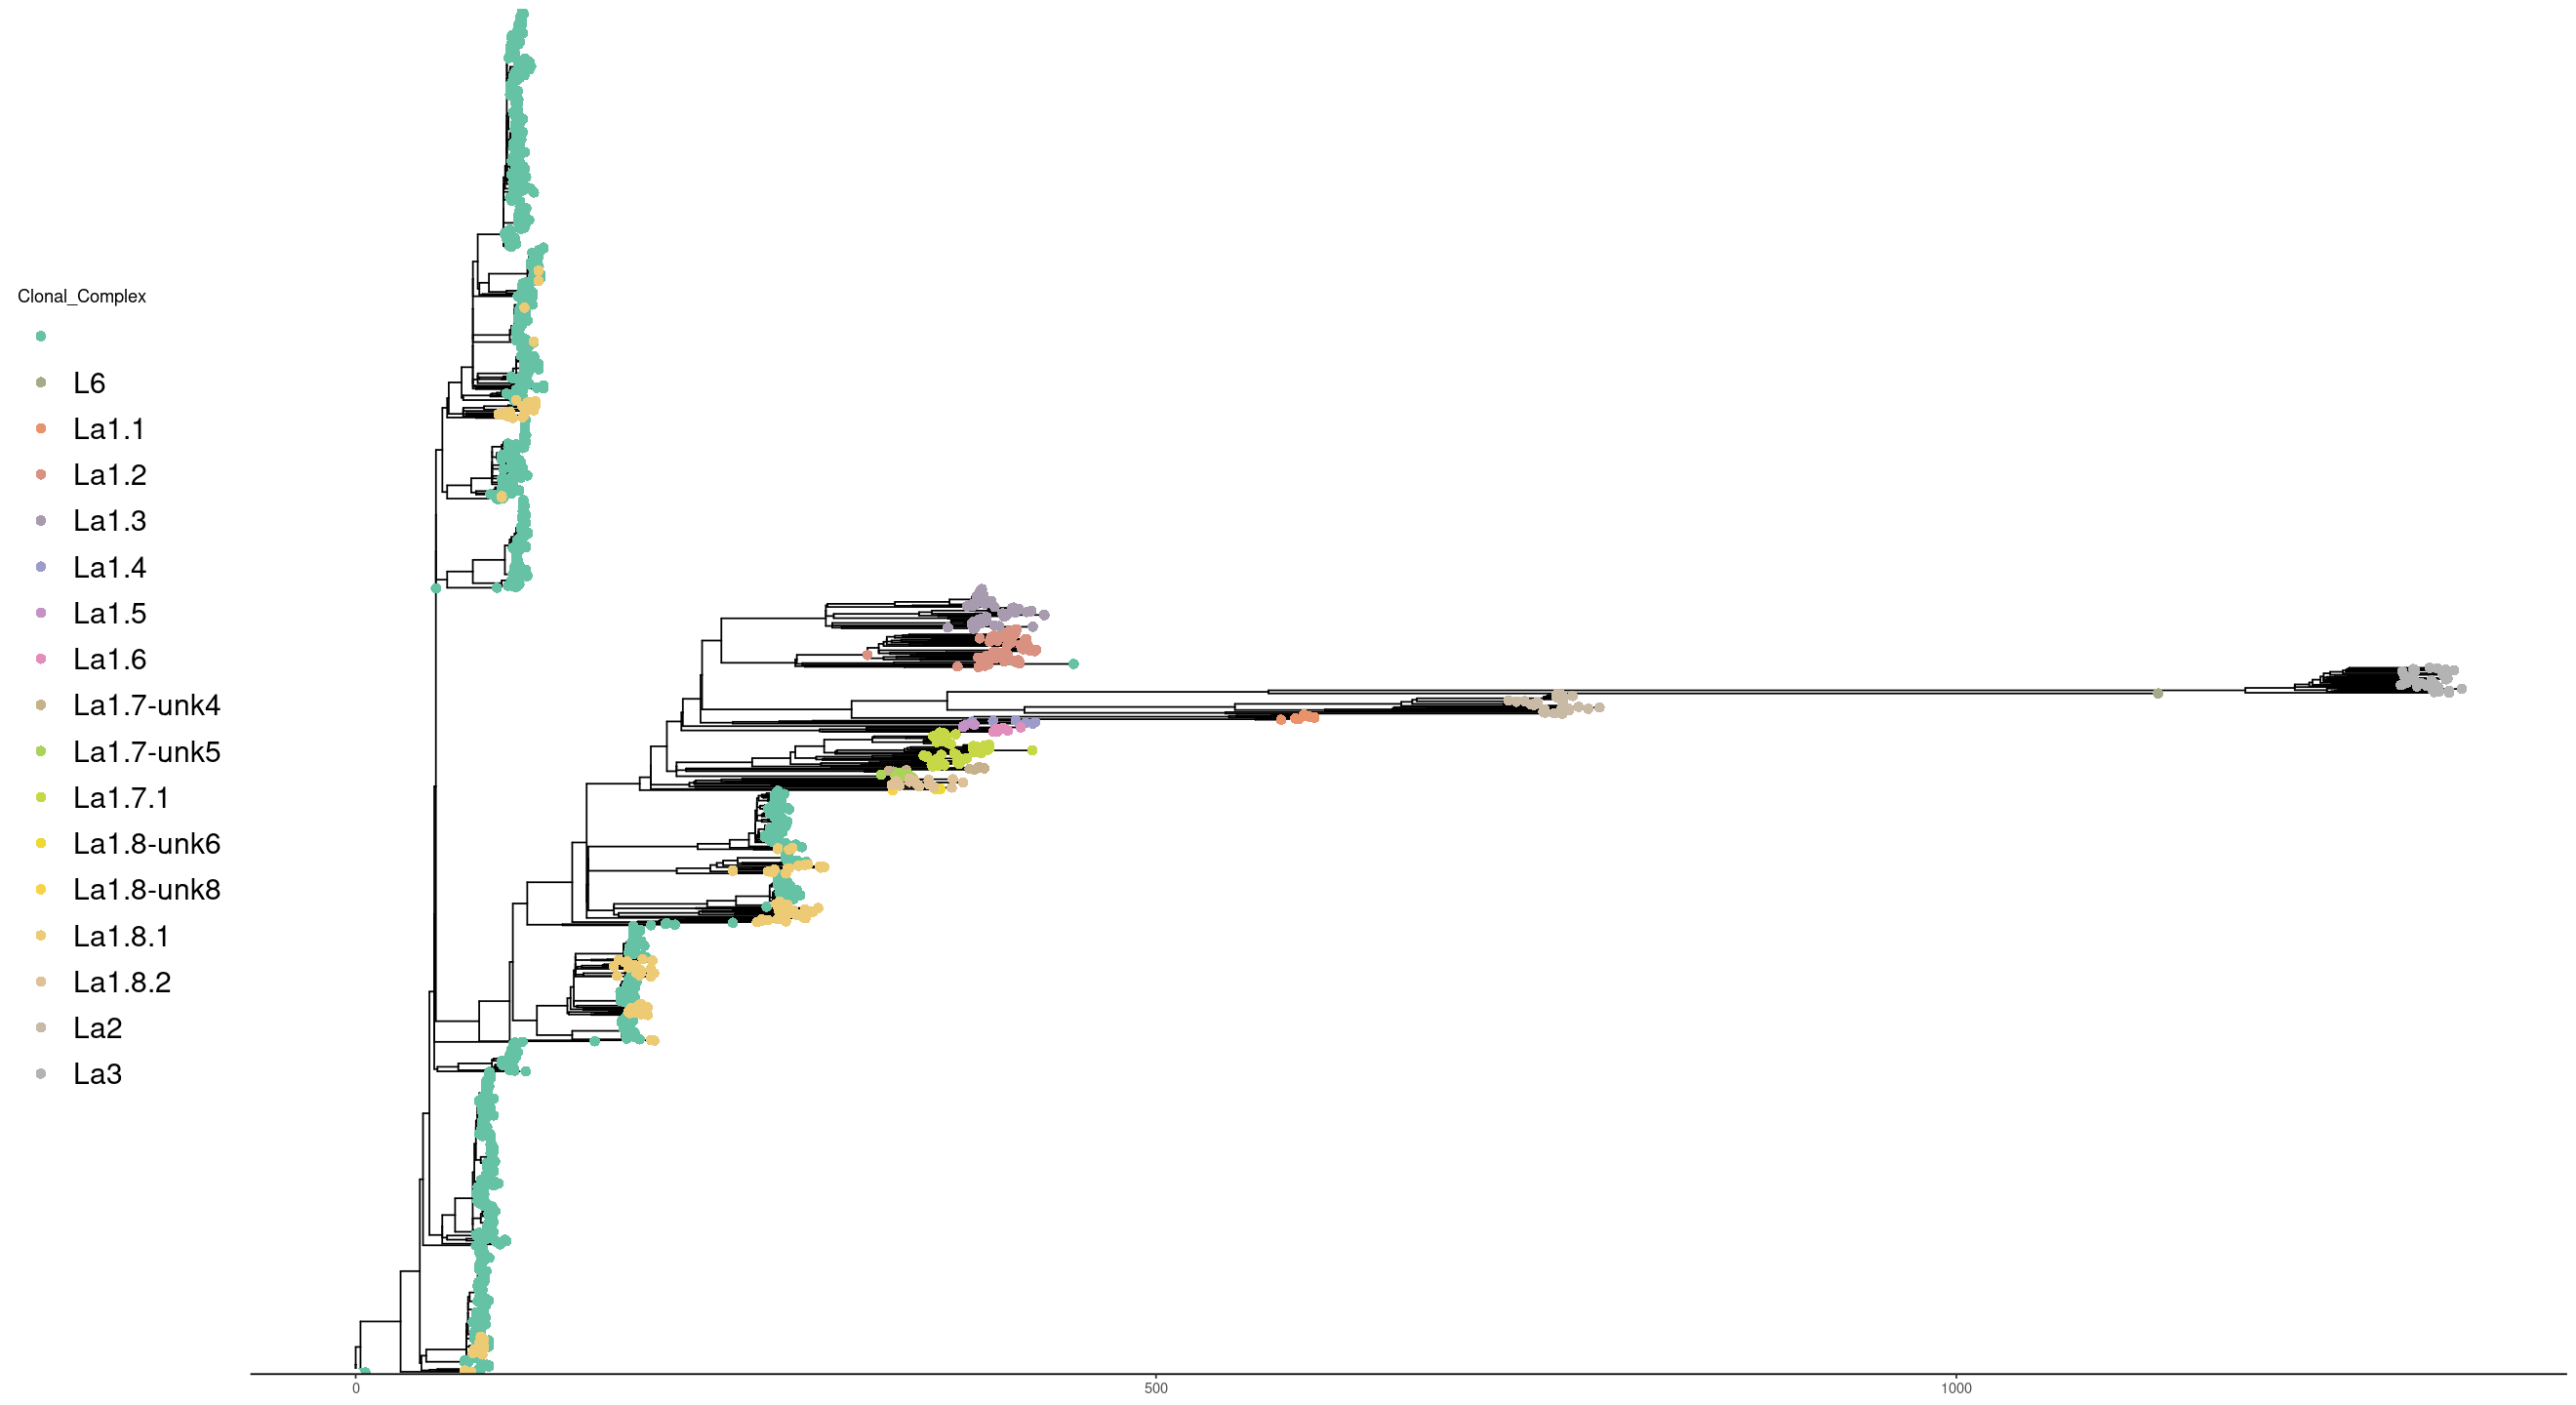

In [90]:
#randtips<-sample(combtree$tip.label,70)
#randtree <- keep.tip(combtree, randtips)
tips<-row.names(glmeta[glmeta$Clonal_Complex %in% c('La3','La2'),])
stree<-drop.tip(combtree,tips)
ggplottree(stree, cmeta, layout='rect', cols=c('Clonal_Complex'), cmaps=c('Set2','Paired'))

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


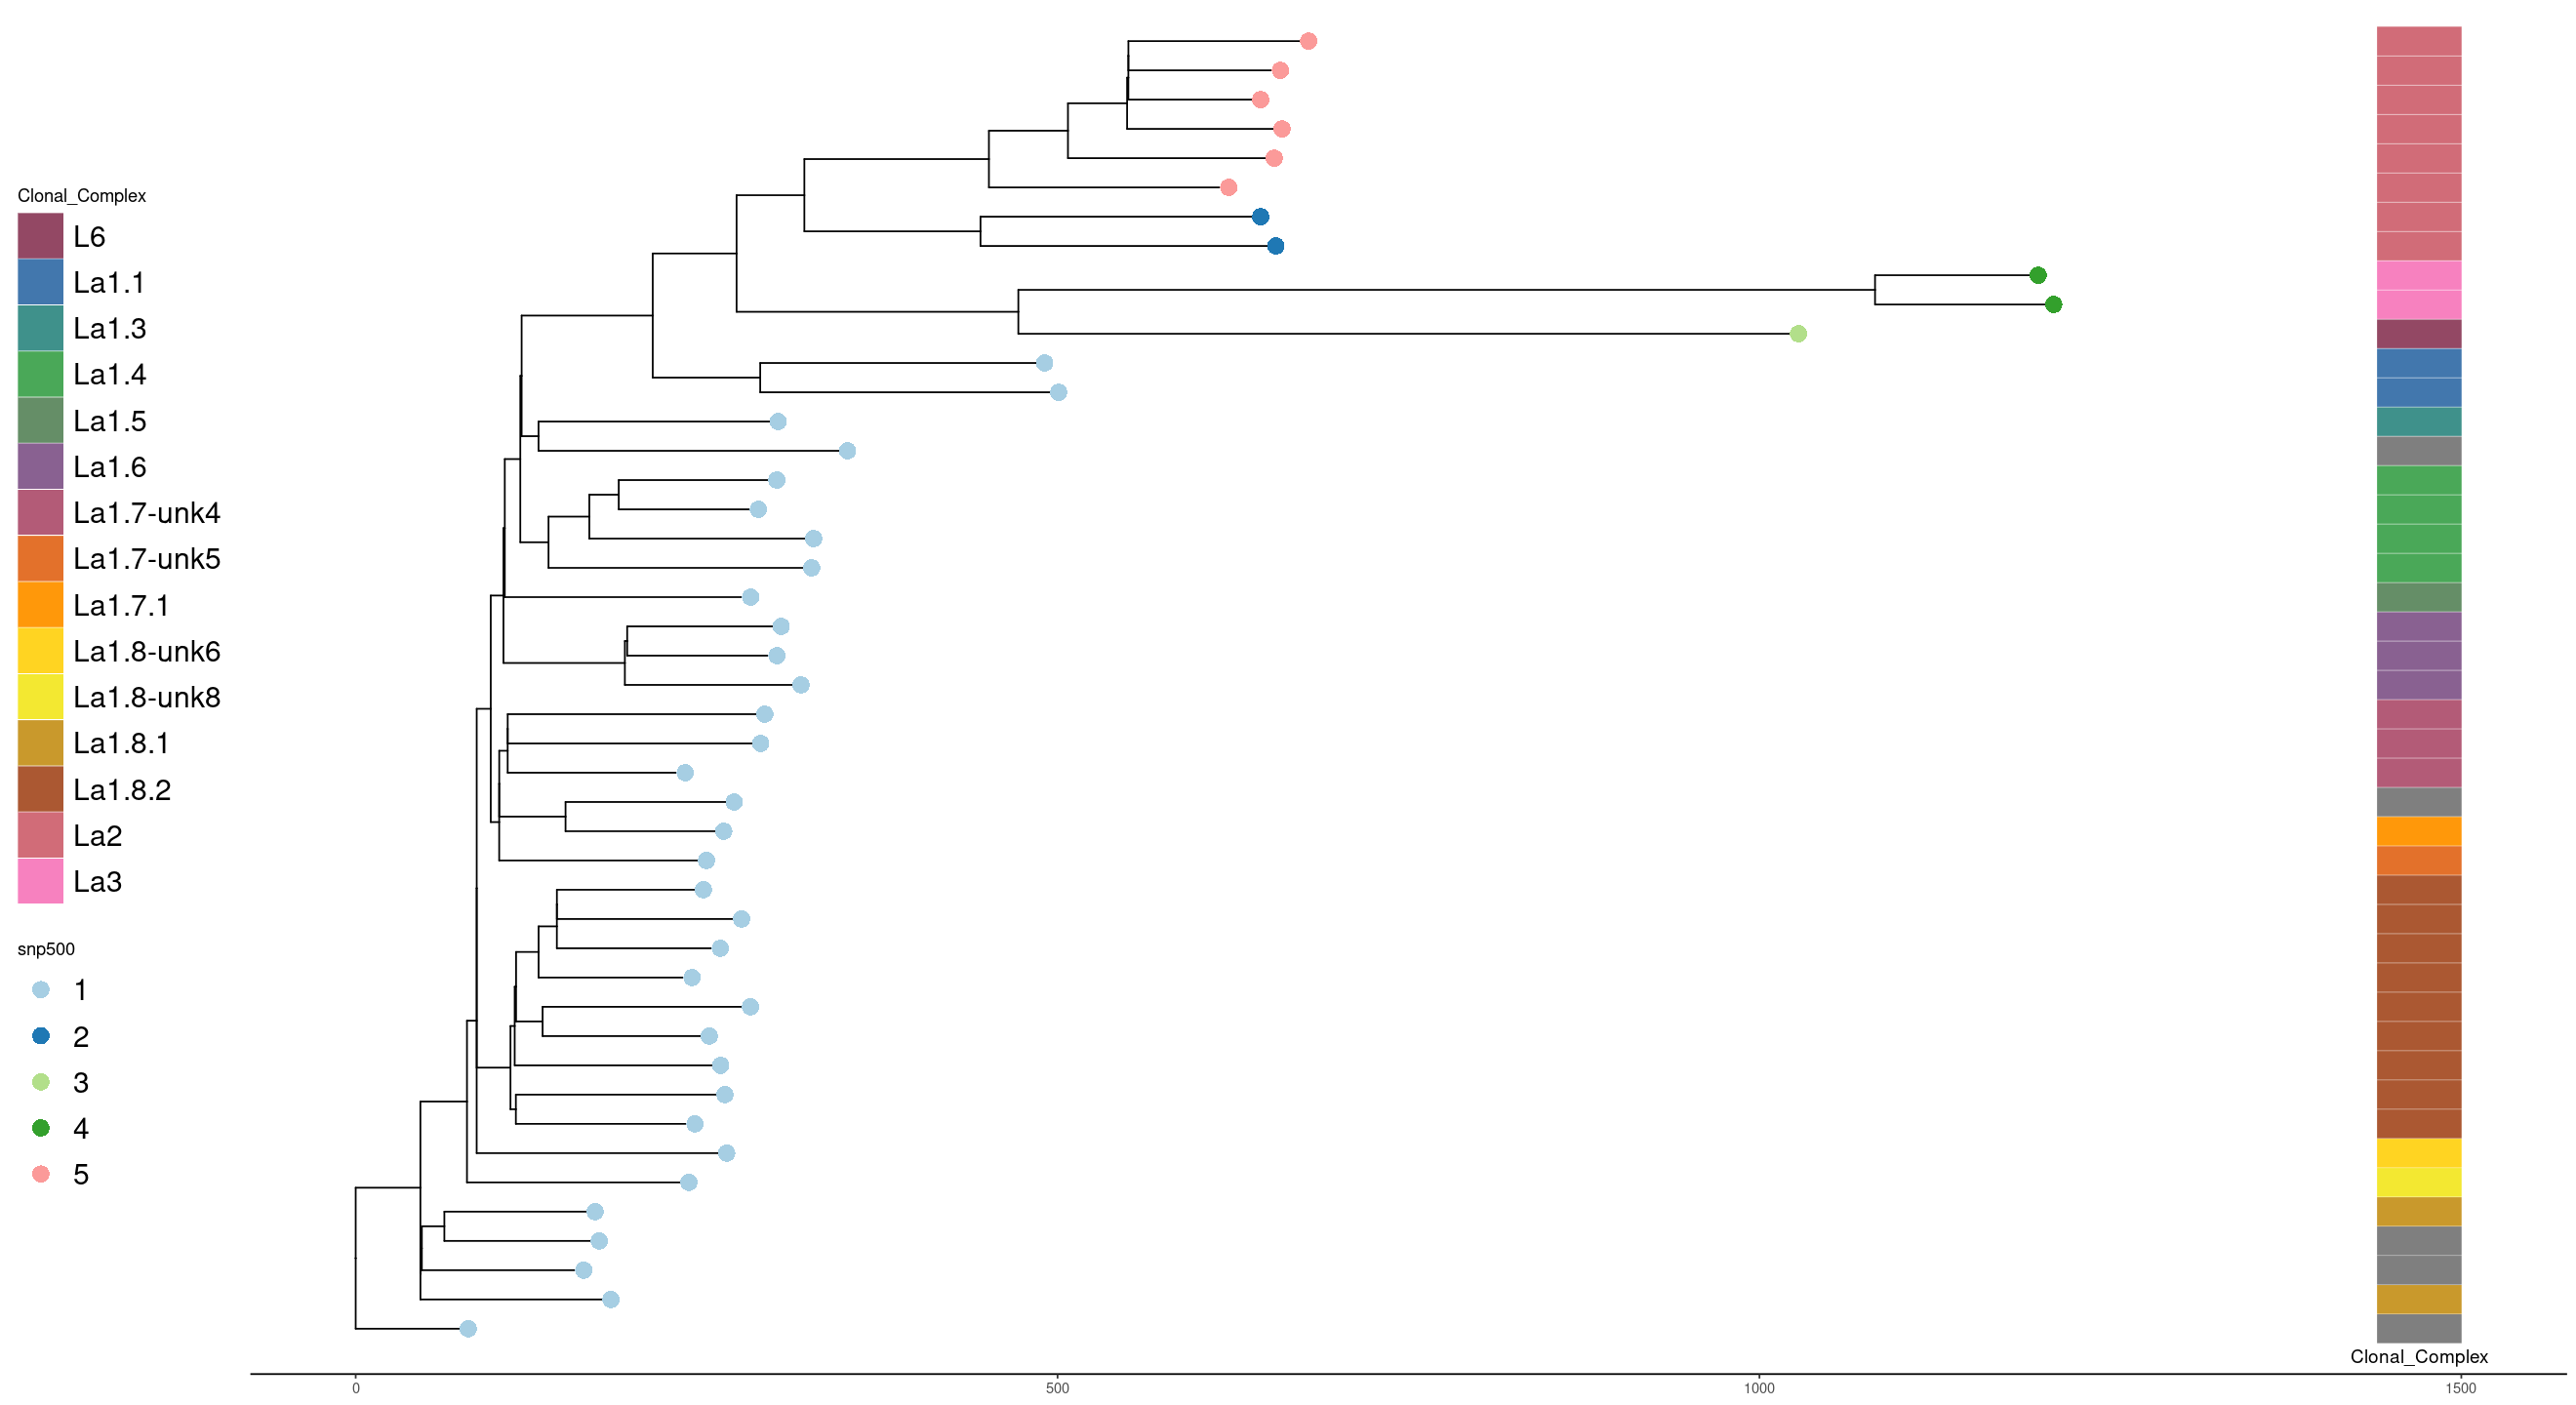

In [91]:
options(repr.plot.width=22, repr.plot.height=12)
uniq <- row.names(distinct(cmeta,snp200,.keep_all = TRUE))
stree <- keep.tip(combtree, uniq)
ggplottree(stree, cmeta, layout='rect', cols=c('snp500','Clonal_Complex'), cmaps=c('Paired','Set1','Set2'), tipsize=5, offset=100)

In [ ]:
p1<-ggplottree(stree, cmeta, layout='unrooted', cols=c('snp500'), cmaps=c('Set1'), tipsize=5)
p2<-ggplottree(stree, cmeta, layout='unrooted', cols=c('Species'), cmaps=c('Paired'), tipsize=5)
p1+p2

In [ ]:
options(repr.plot.width=22, repr.plot.height=12)
h1<-c('snp500','Clonal_Complex')
h2<-c(h1,c('RD149','RD3','RD5','RD5oryx.','RDAf2','RDWicklow'))
cm1<-rep('Greys',length(h2))
cm<-c(c('Set1','Paired'),cm1)
ggplottree(stree, cmeta, layout='rect', cols=h2, cmaps=cm, tipsize=5, offset=90)

## for strain selection

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


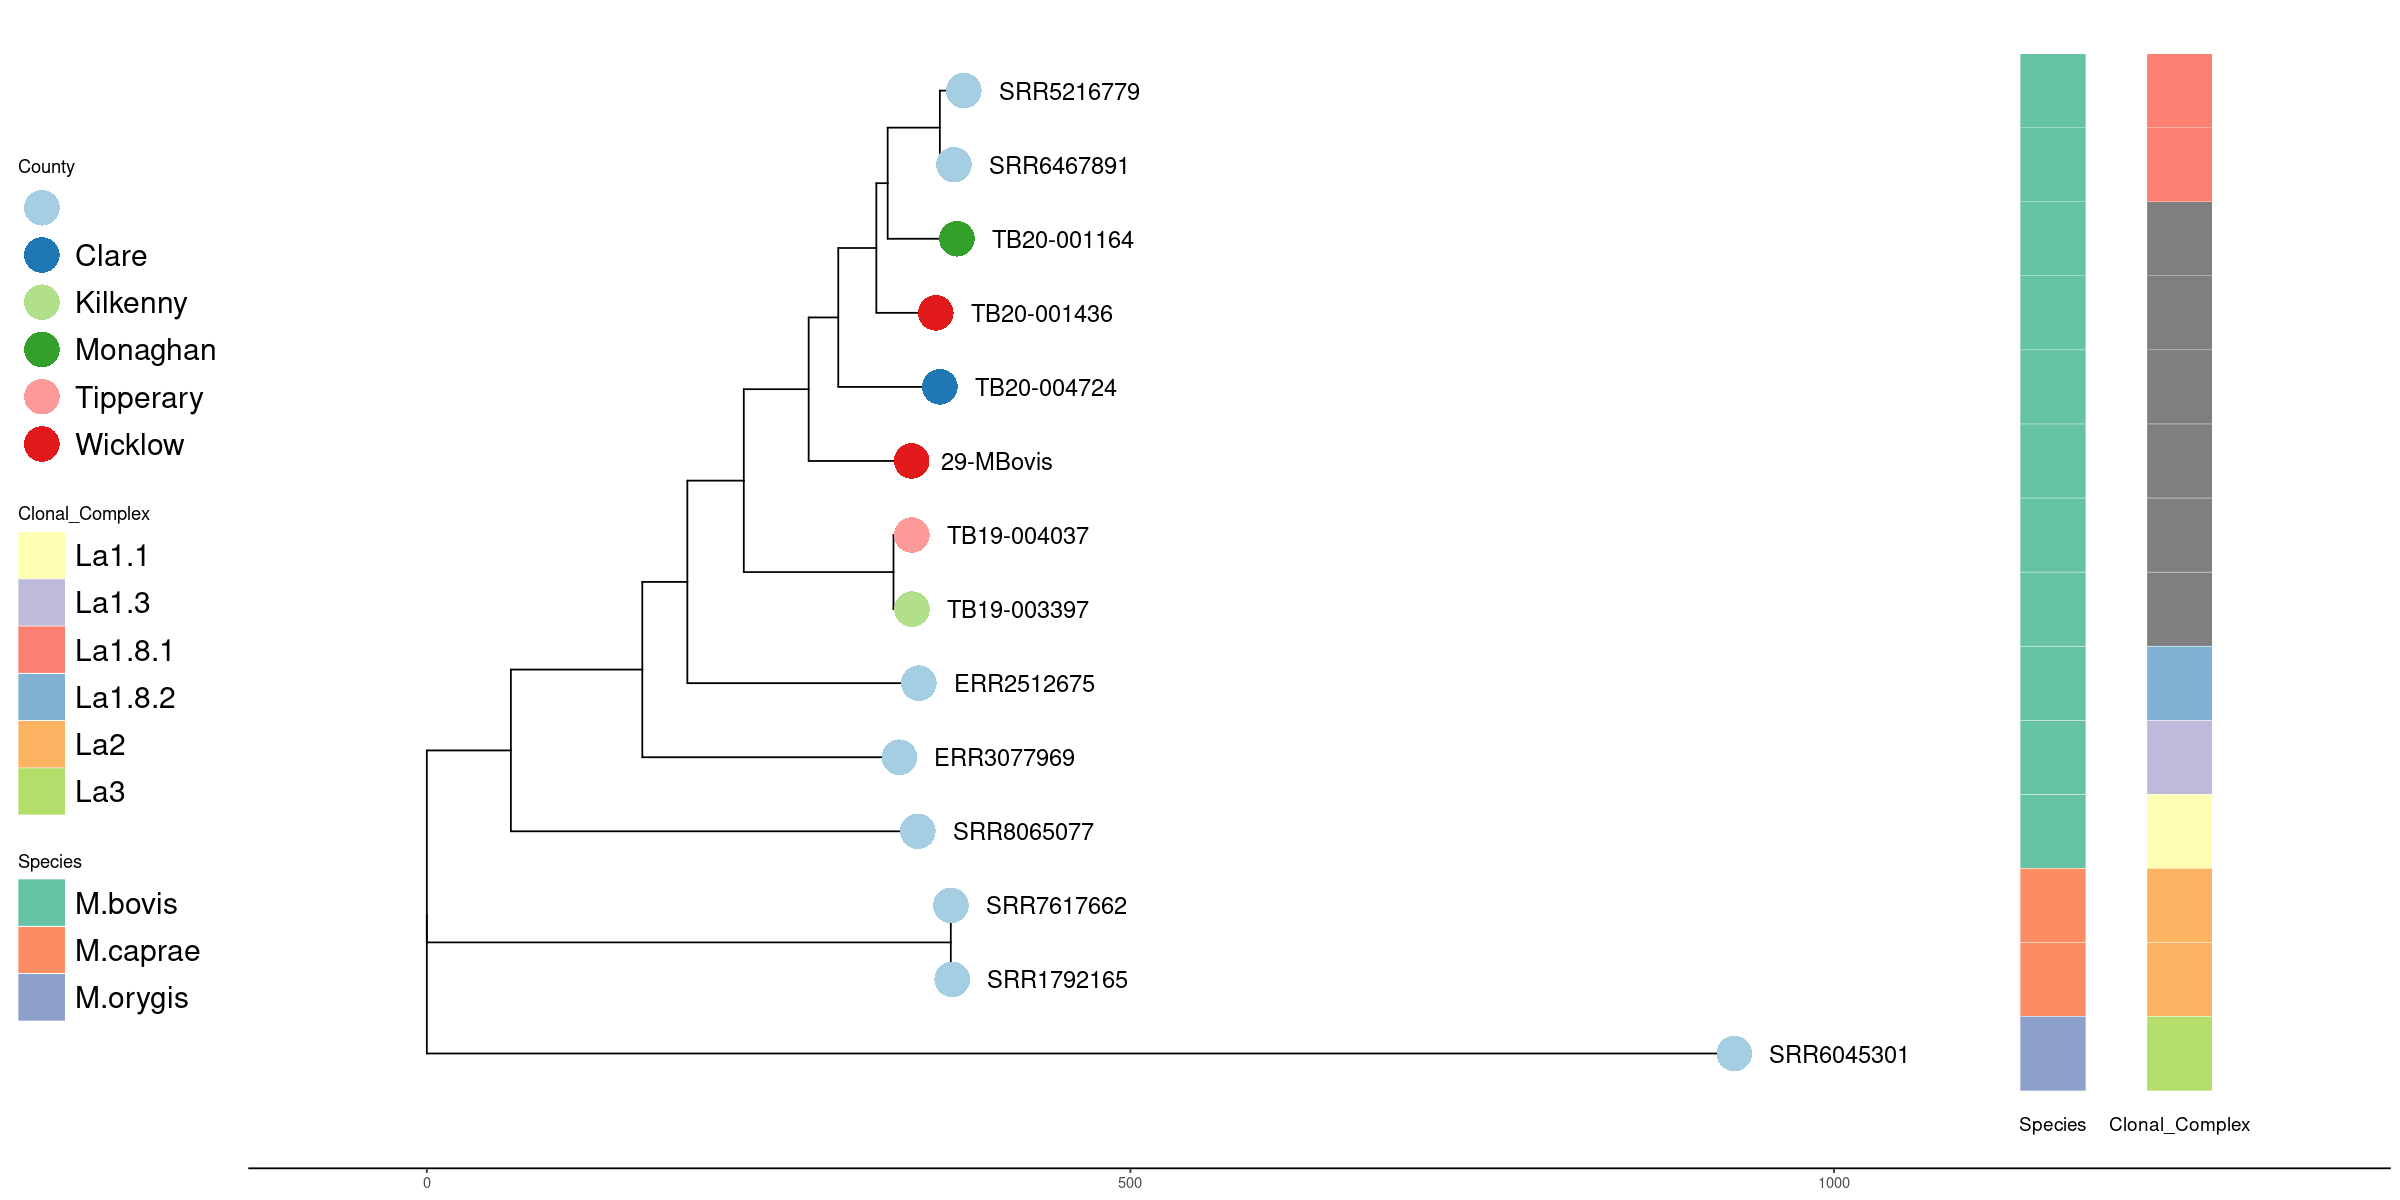

In [146]:
options(repr.plot.width=20, repr.plot.height=10)
selected <- c('TB19-004037','TB19-003397','TB20-001164','TB20-004724','TB20-001436','29-MBovis',
              'SRR1792165','SRR7617662','SRR6045301',#outgroups
              'SRR5216779','SRR6467891','ERR2512675',#UK
              'SRR8065077','ERR3077969')#other

#tips<-row.names(glmeta[glmeta$Clonal_Complex %in% c('La3','La2'),])
stree<-keep.tip(combtree,selected)
stree <- root(stree,'SRR6045301')
ggplottree(stree, cmeta, layout='rect', cols=c('County','Species','Clonal_Complex'), cmaps=c('Paired','Set2','Set3'), tipsize=10, offset=90, tiplabel='SeqID')

## Ireland

In [ ]:
options(repr.plot.width=22, repr.plot.height=14)
ggplottree(iretree,iremeta,cols=c('snp200','County'),cmaps=c('Set1','Paired'),tipsize=2,layout='circular')

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


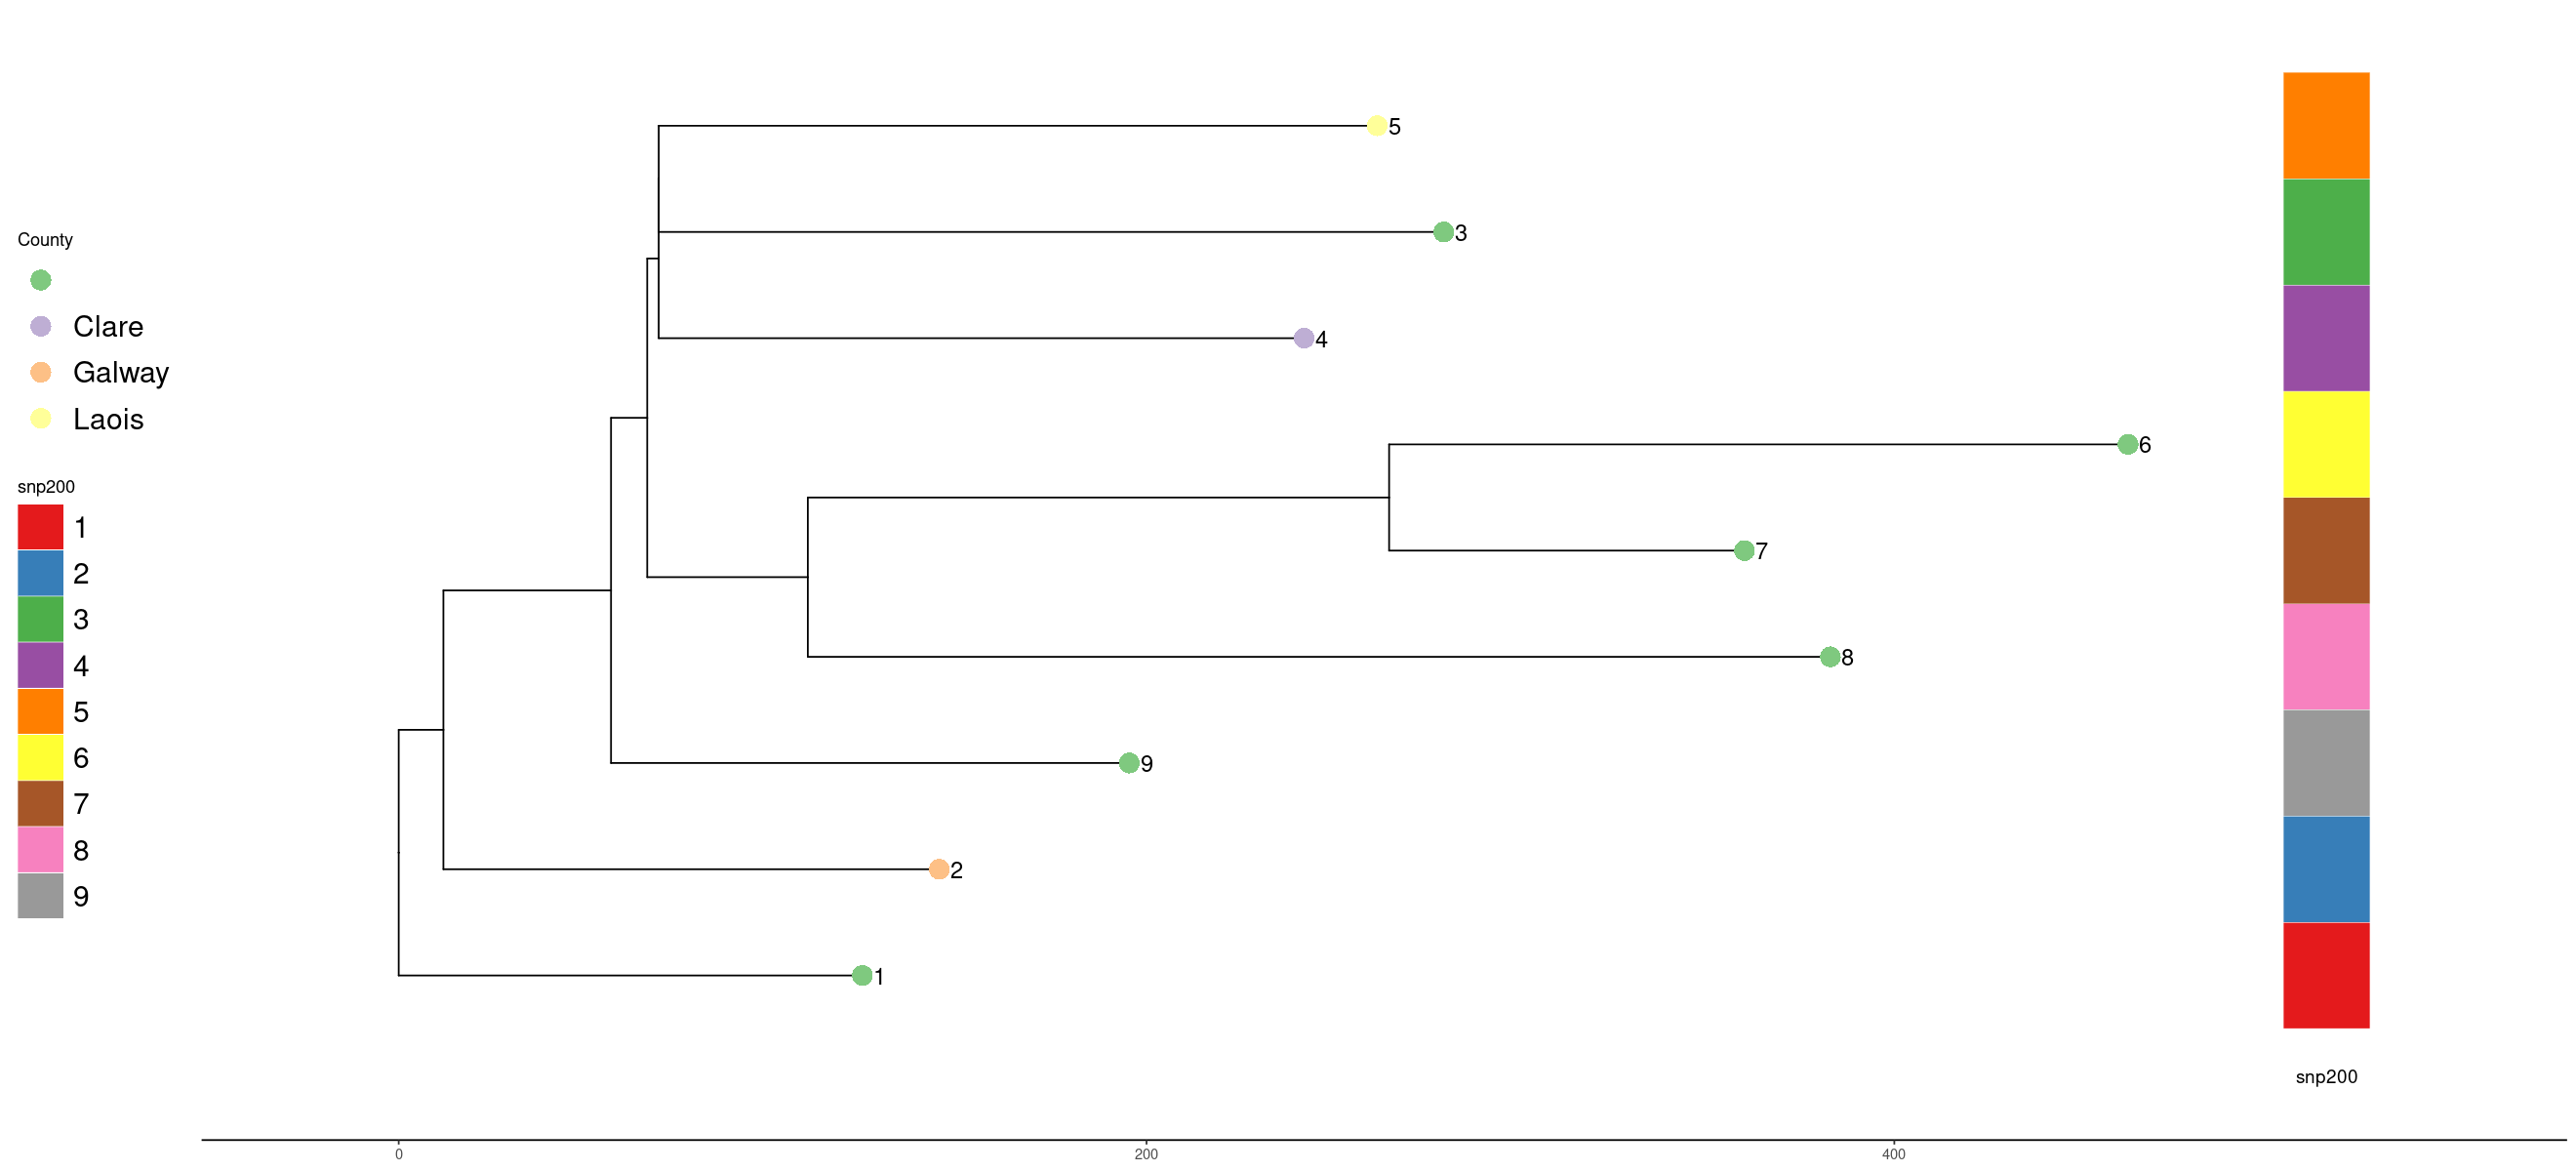

In [66]:
uniq <- row.names(distinct(iremeta,snp200,.keep_all = TRUE))
stree <- keep.tip(iretree, uniq)
options(repr.plot.width=22, repr.plot.height=10)
ggplottree(stree,iremeta,cols=c('County','snp200'),cmaps=c('Accent','Set1'),layout='rect',tipsize=6, tiplabel='snp200',offset=15)


In [ ]:
counties=c('Monaghan','Wicklow','UK')
tips<-row.names(iremeta[iremeta$County %in% counties,])
stree<-keep.tip(iretree,tips)

options(repr.plot.width=22, repr.plot.height=10)
ggplottree(stree,iremeta,cols=c('County','snp200'),cmaps=c('Set2','Set1'),layout='rect',tipsize=2,offset=15)

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


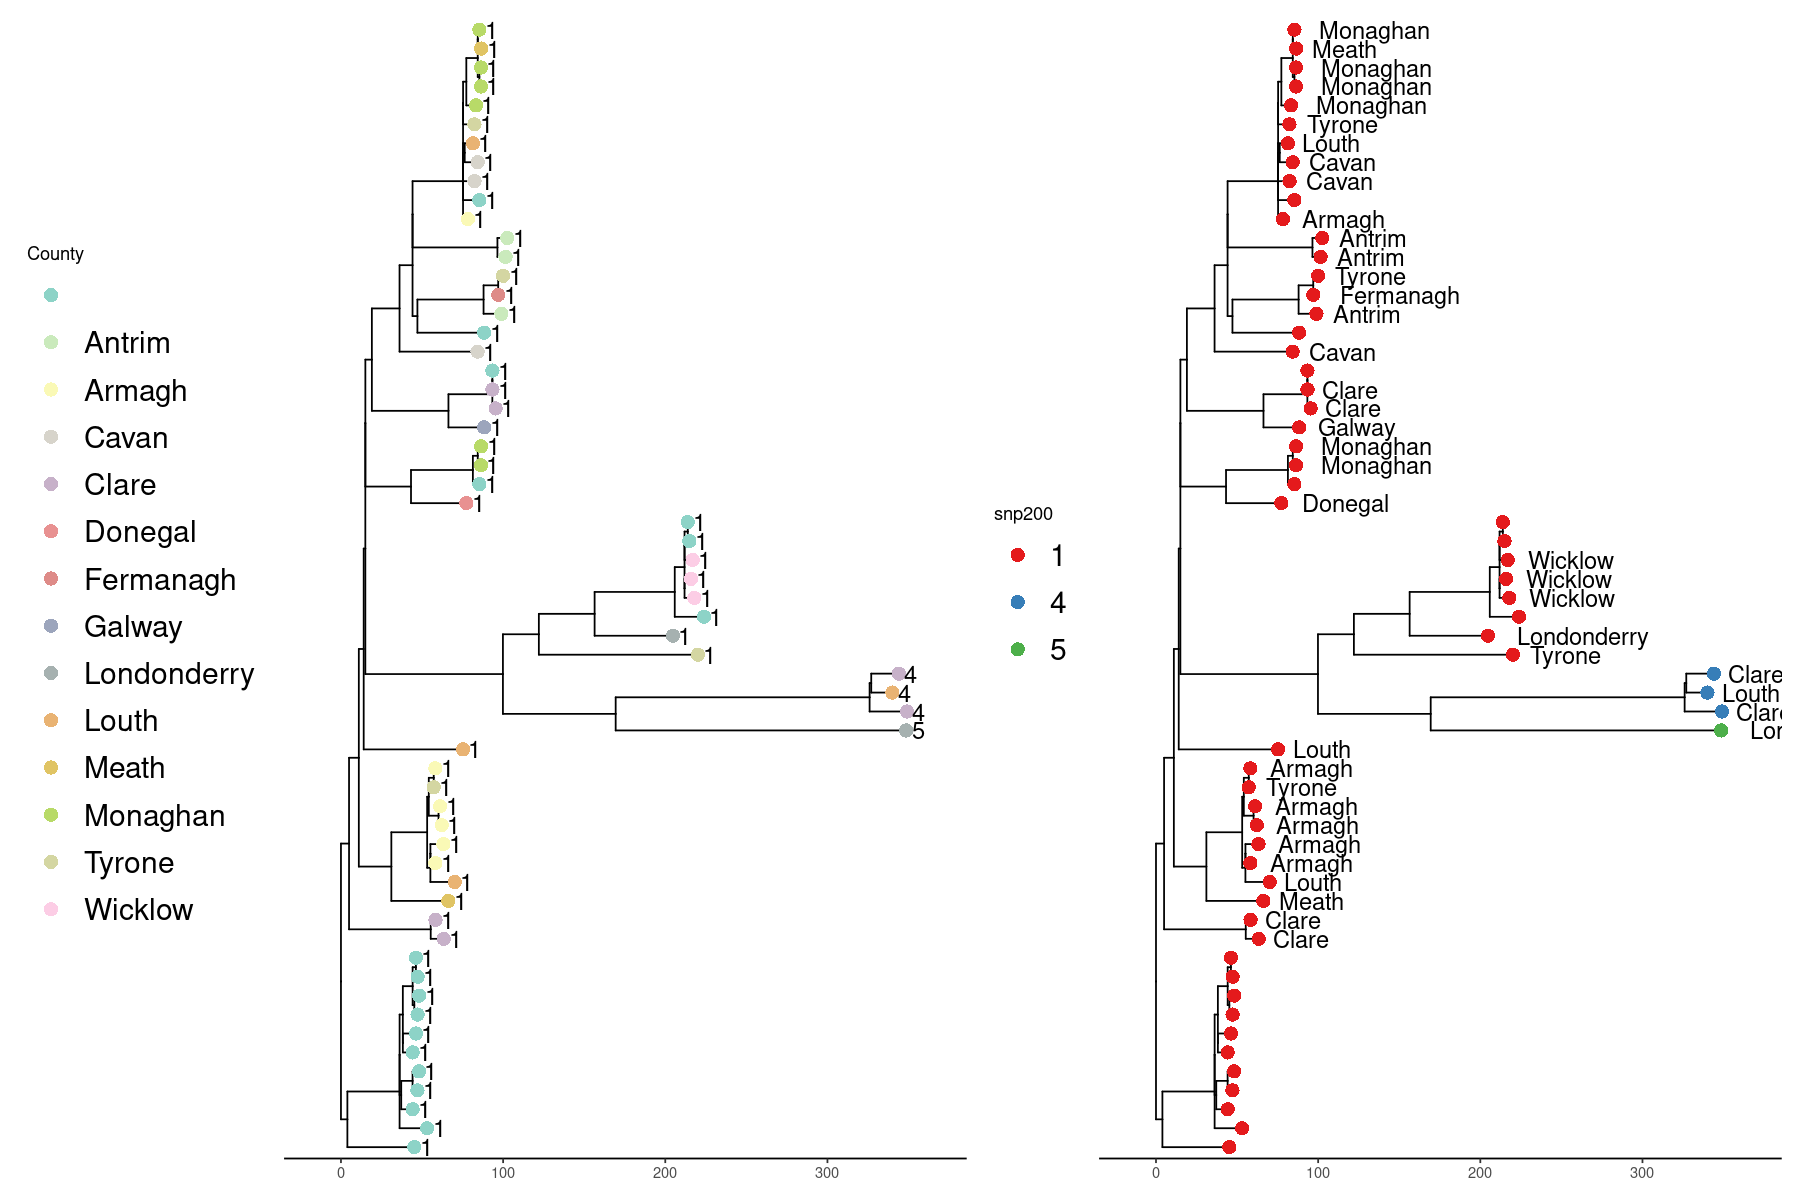

In [74]:
options(repr.plot.width=25, repr.plot.height=10)
#set.seed(1)
randtips<-sample(iretree$tip.label,60)
randtree <- keep.tip(iretree, randtips)
options(repr.plot.width=15, repr.plot.height=10)
p1<-ggplottree(randtree, iremeta, layout='rect','County', cmap='Set3', tipsize=4, tiplabel='snp200')
p2<-ggplottree(randtree, iremeta, layout='rect','snp200', cmap='Set1', tipsize=4, tiplabel='County')
p1+p2

## outliers

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


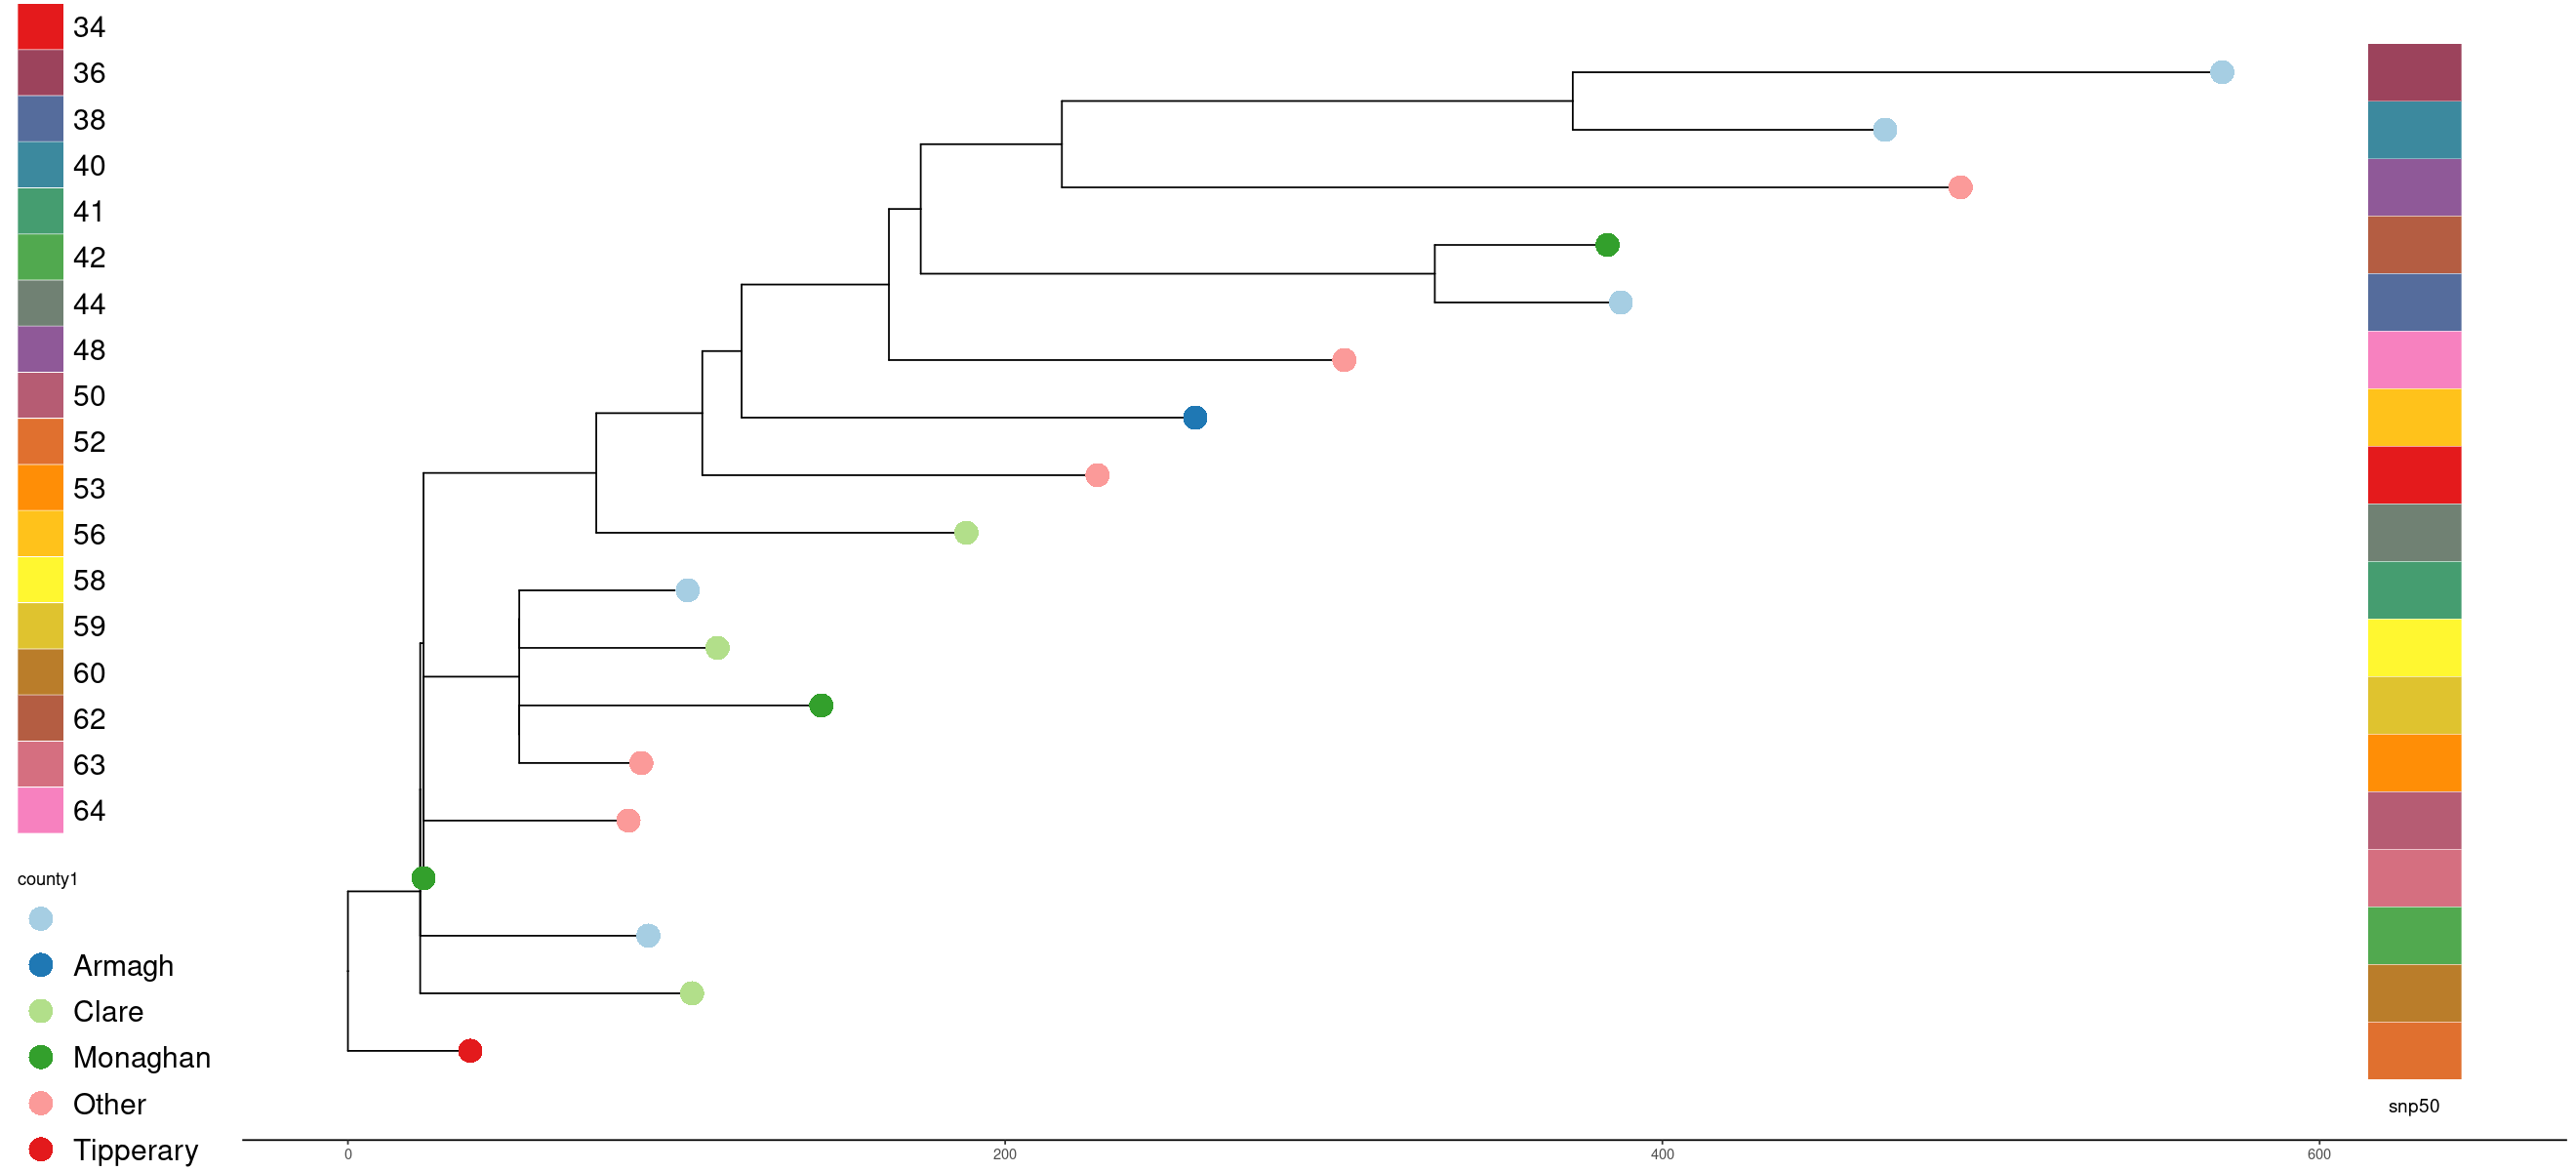

In [54]:
rare<-c('38', '41', '42', '34', '52', '64', '63', '58', '50', '60', '40', '56', '59', '48', '36', '44', '53', '62')
tips<-row.names(iremeta[iremeta$snp50 %in% rare,])
#tips <- c(tips,sample(iretree$tip.label,10))
stree<-keep.tip(iretree,tips)

options(repr.plot.width=22, repr.plot.height=10)
ggplottree(stree,iremeta,cols=c('county1','snp50'),cmaps=c('Paired','Set1'),layout='rect',tipsize=7,offset=15)

## wicklow

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


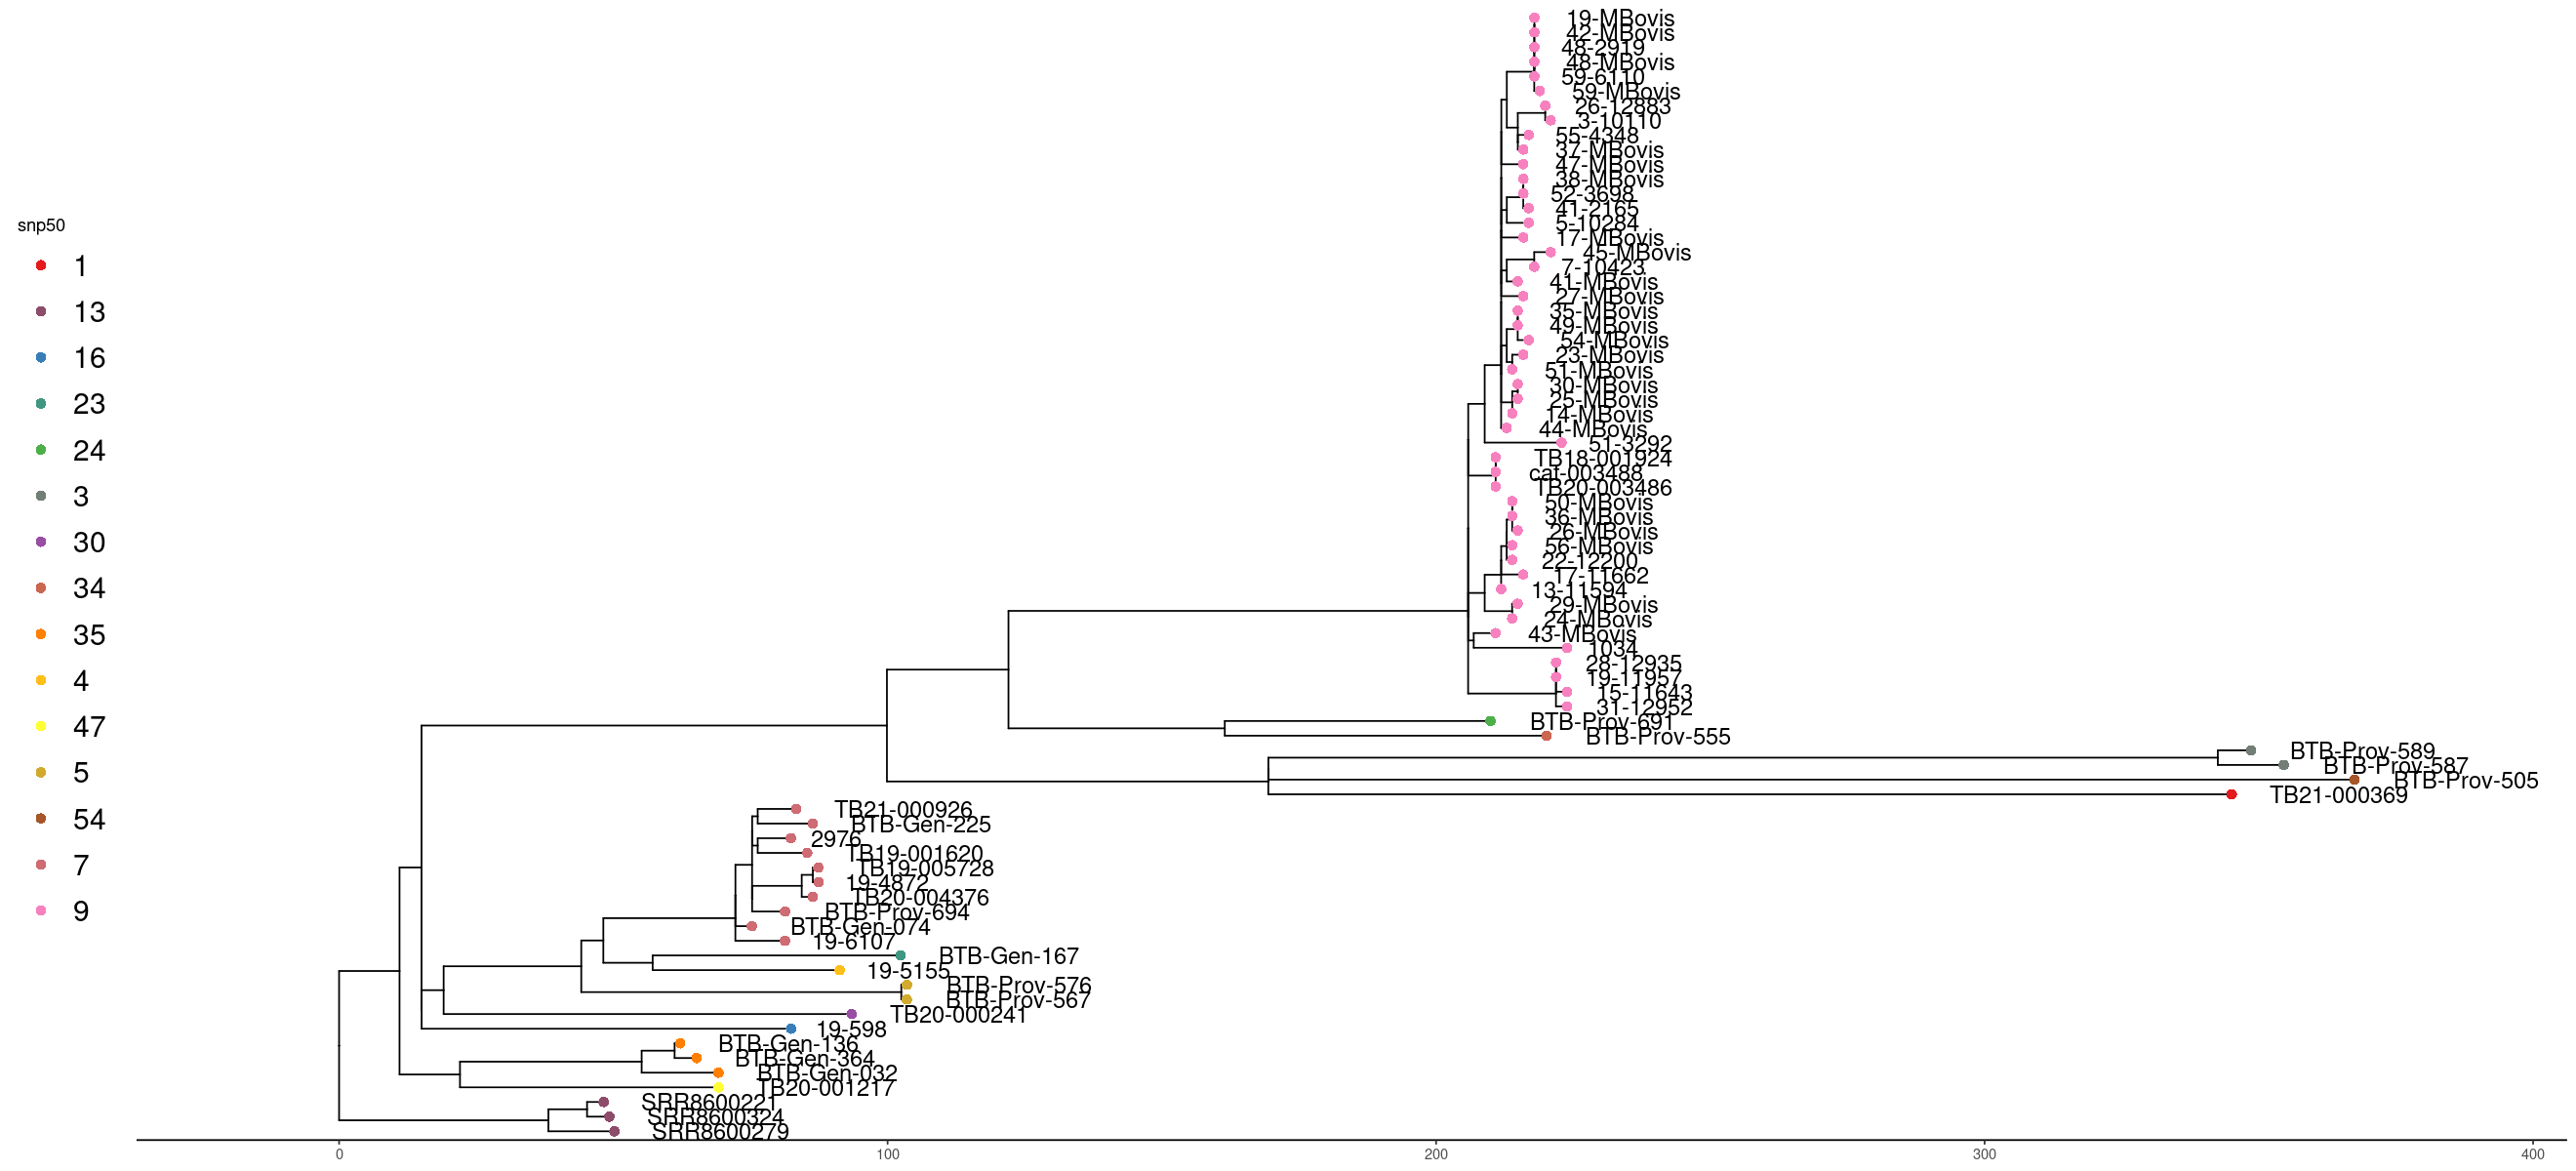

In [45]:
x<-read.table('/storage/btbgenie/wicklow_results/samples.csv',sep=',',header=TRUE,row.names=2)
randtips<-sample(iretree$tip.label,30)
tips<-x$sample
tips<- c(tips,randtips)
stree<-keep.tip(iretree,tips)
options(repr.plot.width=22, repr.plot.height=10)
ggplottree(stree,iremeta,'snp50',layout='rect',cmap='Set1',tiplabel=TRUE)